# CNCITY - cassandraConnect


# Importing python packages 

In [1]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
import os
import sys

# Data Analysis
import pandas as pd

# Cassandra
from connection_manager import cassandraConnect
from cassandra.query import dict_factory

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import tqdm as tqdm
from tabulate import tabulate


# Importing the dataset - saved it to a variable called 'df'

In [4]:
PORT = 9042
KEYSPACE = "cncity_server"
TABLE = "all_data"

# Source DB
CONTACT_POINTS = ["39.118.41.24"]
USERNAME = "cnscada"
PW = "cnscada123!@#"

cc = cassandraConnect(CONTACT_POINTS, USERNAME, PW)
cc.session.row_factory = dict_factory

Connected to Cassandra Successfully: ['39.118.41.24'] 9042


In [5]:
use_machine_code = 1
use_day = 20240603
# save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

###################################

query = """
    SELECT *
    FROM {keyspace_name}.{table_name}
    WHERE machine_code = {query_machine_code}
    AND day = {query_day}
""".format(
    keyspace_name = KEYSPACE,
    table_name = TABLE,
    query_machine_code = use_machine_code,
    query_day = use_day
)

query_result = cc.session.execute(query)
###################################

# Pandas DataFrame으로 전환
df_1 = pd.DataFrame(list(query_result)).sort_values(by='time')
# df.to_csv(save_path, index=False)

print(df_1.shape)
df_1.head()

(86261, 22)


machine_code       day  time  door_open  electricity_1  electricity_2  \
86260             1  20240603     0          0        -1385.0            0.0   
86259             1  20240603     1          0        -1385.0            0.0   
86258             1  20240603     2          0        -1385.0            0.0   
86257             1  20240603     3          0        -1385.0            0.0   
86256             1  20240603     4          0        -1385.0            0.0   

       gas_leak  is_maintenance  machine_type  network_status  ...  power_on  \
86260         0               0             1               0  ...         0   
86259         0               0             1               0  ...         0   
86258         0               0             1               0  ...         0   
86257         0               0             1               0  ...         0   
86256         0               0             1               0  ...         0   

       pressure_1  pressure_2  ssv1  ssv2  status_electricity_1  \
86260       0.798       2.130     0     0                     0   
86259       0.798       2.130     0     0                     0   
86258       0.798       2.130     0     0                     0   
86257       0.798       2.144     0     0                     0   
86256       0.798       2.144     0     0                     0   

       status_electricity_2  status_pressure_1  status_pressure_2  weektime  
86260                     0                  0                  0         0  
86259                     0                  0                  0         0  
86258                     0                  0                  0         0  
86257                     0                  0                  0         0  
86256                     0                  0                  0         0  

[5 rows x 22 columns]

In [6]:
def query(day, machine_code):
    use_machine_code = machine_code
    use_day = day
    # save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

    ###################################

    query = """
        SELECT *
        FROM {keyspace_name}.{table_name}
        WHERE machine_code = {query_machine_code}
        AND day = {query_day}
    """.format(
        keyspace_name = KEYSPACE,
        table_name = TABLE,
        query_machine_code = use_machine_code,
        query_day = use_day
    )

    query_result = cc.session.execute(query)
    ###################################

    # Pandas DataFrame으로 전환
    df_1 = pd.DataFrame(list(query_result)).sort_values(by='time')
    # df.to_csv(save_path, index=False)

    # print(df_1.shape)
    # print(df_1.head())
    return df_1


In [7]:
def process_dataframe(df, aggregation):
    # Extract hour from 'Time' column (assuming 'Time' is in seconds since midnight)
    df['Hour'] = df['time'].dropna() // 10000
    
    # Group by 'Hour' and aggregate the data
    if aggregation == 'mean':
        result_df = df.groupby('Hour').mean().reset_index()
    elif aggregation == 'median':
        result_df = df.groupby('Hour').median().reset_index()
    elif aggregation == 'mode':
        # Mode can return multiple values, we need the first one
        result_df = df.groupby('Hour').agg(lambda x: x.mode().iloc[0]).reset_index()
    elif aggregation == 'max': 
        result_df = df.groupby('Hour').max().reset_index()
    else:
        raise ValueError("Aggregation method not supported. Use 'mean', 'median', or 'mode'.")
    
    # Drop the 'Time' column as it's not needed in the result
    result_df = result_df.drop(columns=['time'])
    
    return result_df

# result_df = process_dataframe(df,'max')

# Visualization - plotted each variable (20240603)

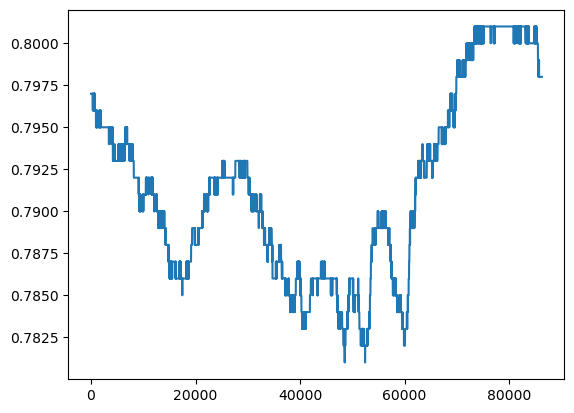

In [8]:
plt.plot(df_1['pressure_1'])

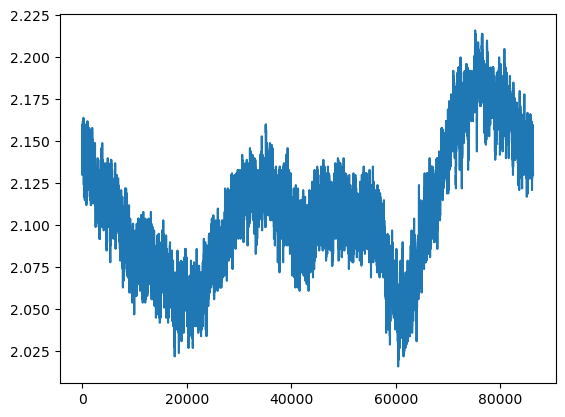

In [9]:
plt.plot(df_1['pressure_2'])

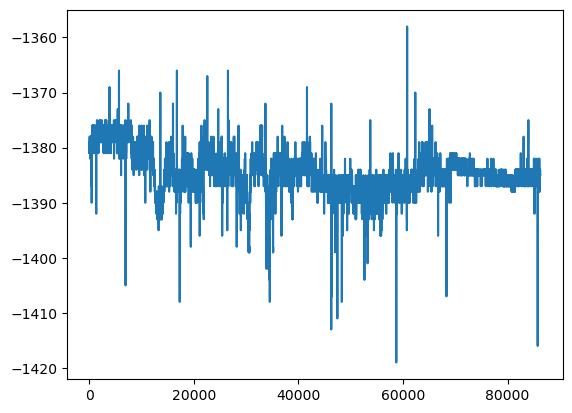

In [10]:
plt.plot(df_1['electricity_1'])

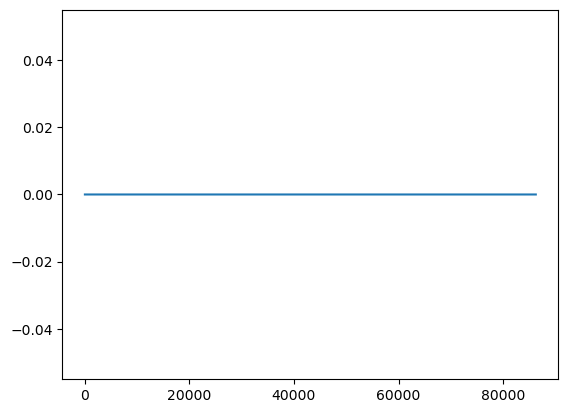

In [11]:
plt.plot(df_1['electricity_2'])

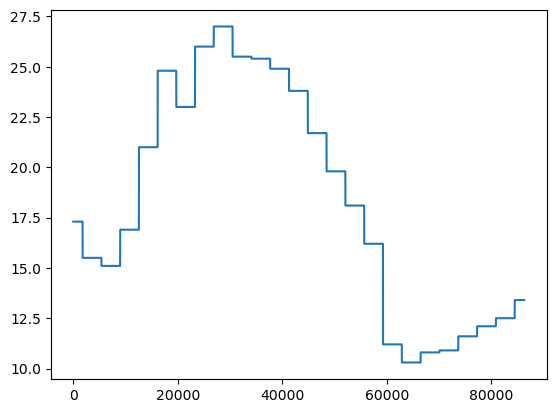

In [12]:
plt.plot(df_1['outside_temperature'])

# Linear Regression Plots (20240603)

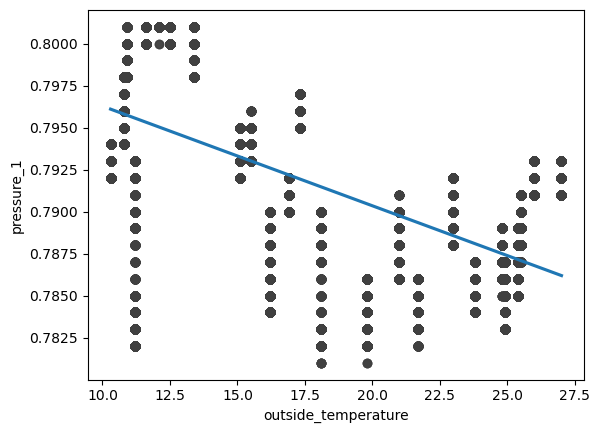

In [13]:
# linear regression with outside_temperature and pressure_1
ax = sns.regplot(x='outside_temperature', y= 'pressure_1', data=df_1, ci=None, scatter_kws=dict(color='0.25'))

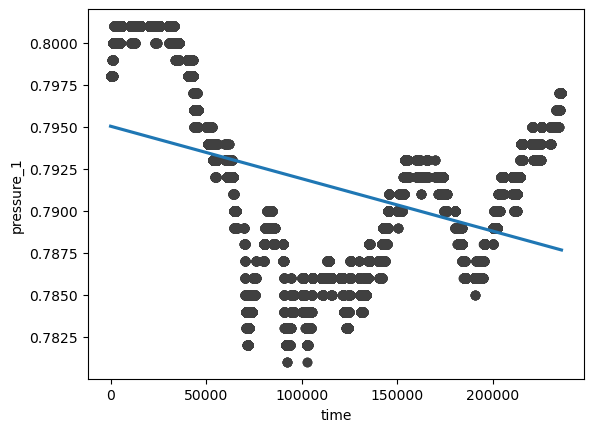

In [14]:
# linear regression with time and pressure_1
ax = sns.regplot(x='time',y='pressure_1',data=df_1,ci = None, scatter_kws = dict(color = '0.25'))

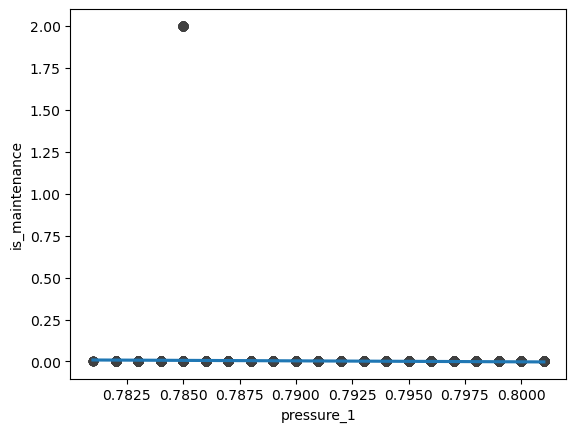

In [15]:
# linear regression with pressure_1 and is_maintenance (doesn't provide us with that much insight)
ax = sns.regplot(x = 'pressure_1', y='is_maintenance',data= df_1,ci = None, scatter_kws = dict(color = '0.25'))

# Linear regression (using the python package), 20240603
1. pressure_1 and outside_temperature

In [16]:
model_gas_and_temp = LinearRegression()

In [17]:
# transforms the columns into numpy arrays
pressure_1_array = np.array(df_1['pressure_1']).reshape(-1,1)
temperature_array= np.array(df_1['outside_temperature']).reshape(-1,1)

In [18]:
# splits the arrays into train and test sets
temp_train, temp_test, pressure_train, pressure_test = train_test_split(temperature_array, pressure_1_array, random_state=104, test_size=0.25, shuffle=True )

In [19]:
# trains the model
model_gas_and_temp.fit(temp_train, pressure_train)

LinearRegression()

In [20]:
# uses the model to predict 'pressure_1' values
predicted_pressure = model_gas_and_temp.predict(temp_test)

In [21]:
# gives us the slope and intercept of the linear regression model
a = float(model_gas_and_temp.coef_)
b = float(model_gas_and_temp.intercept_)
print(f'y = {a:.7f}x + {b:3f}')

y = -0.0005971x + 0.802281


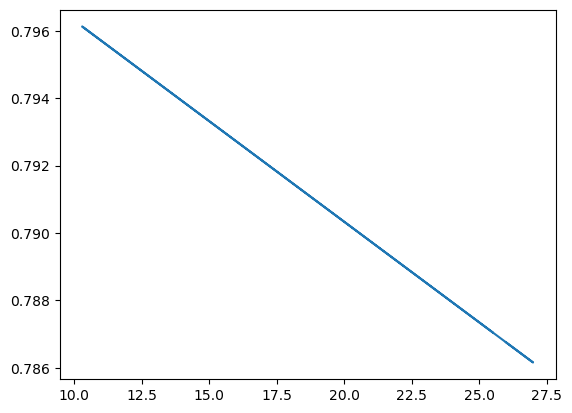

In [22]:
plt.plot(temp_test,predicted_pressure)
plt.xlabel = 'temperature'
plt.ylabel = 'pressure_1'

# Linear regression - now with electricity_1 and pressure_1 (20240603)

In [23]:
model_electricity_pressure = LinearRegression()

In [24]:
# takes the columns and turns them into numpy arrays
electricity_1_array = np.array(df_1['electricity_1']).reshape(-1,1)
pressure_2_array = np.array(df_1['pressure_1']).reshape(-1,1)

In [25]:
# splits the arrays into train and test sets
electricity_train, electricity_test, pressure_train, pressure_test = train_test_split(electricity_1_array, pressure_2_array,random_state=104, test_size=0.25, shuffle=True)

In [26]:
# trains the model
model_electricity_pressure.fit(electricity_train, pressure_train)

LinearRegression()

In [27]:
# uses the model to predict pressure_1
y_pred_pressure = model_electricity_pressure.predict(electricity_test)

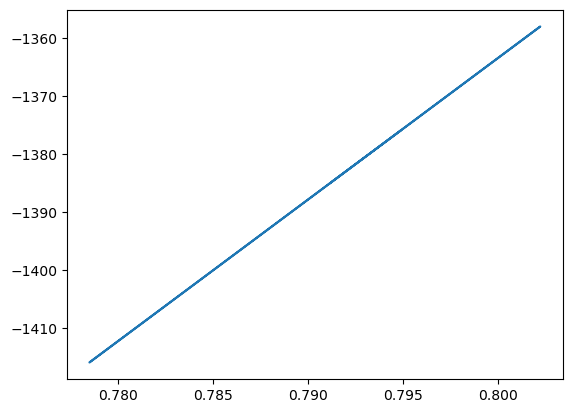

In [28]:
plt.plot(y_pred_pressure, electricity_test)

# Logistic Regression with pressure_1 and is_maintenance (20240603)

In [28]:
model_log = LogisticRegression()

In [29]:
# creates numpy arrays using the columns in our dataframe
maintenance_array = np.array(df_1['is_maintenance']).reshape(-1,1)
time_array = np.array(df_1['time']).reshape(-1,1)
pressure_array = np.array(df_1['pressure_1']).reshape(-1,1)

In [30]:
# splits them into train and test sets
X_train, X_test, y_train, y_test = train_test_split(pressure_array,maintenance_array,random_state=104,test_size=0.25,shuffle=True) 

In [31]:
# trains the model
model_log.fit(X_train, y_train)

/Users/annikaseo-yeonkim/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [32]:
# uses that to predict is_maintenance
y_pred_log = model_log.predict(X_test)

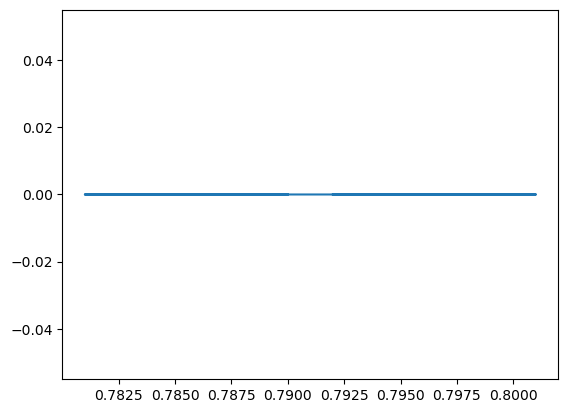

In [33]:
plt.plot(X_test, y_pred_log)

# Autoregression using lag plot (20240603)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

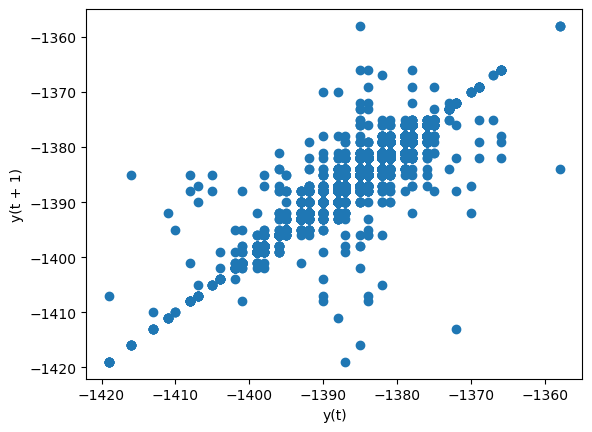

In [34]:
pd.plotting.lag_plot(df_1['electricity_1'],lag=1)

# Autocorrelation plots (20240603)

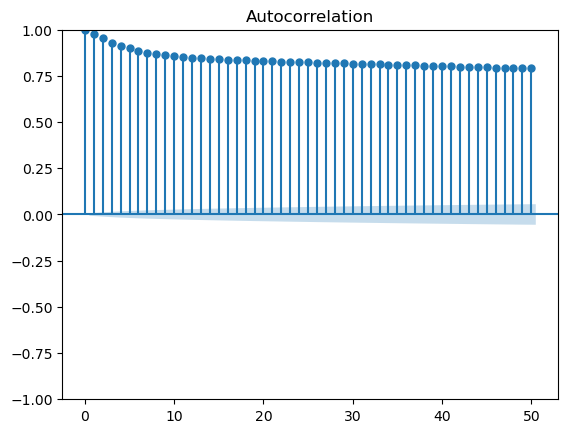

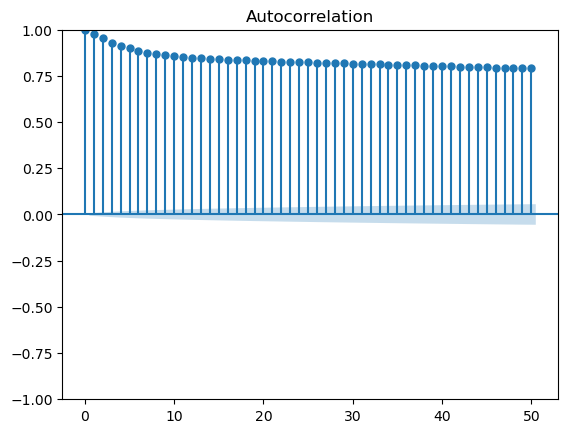

In [35]:
plot_acf(df_1['electricity_1'])

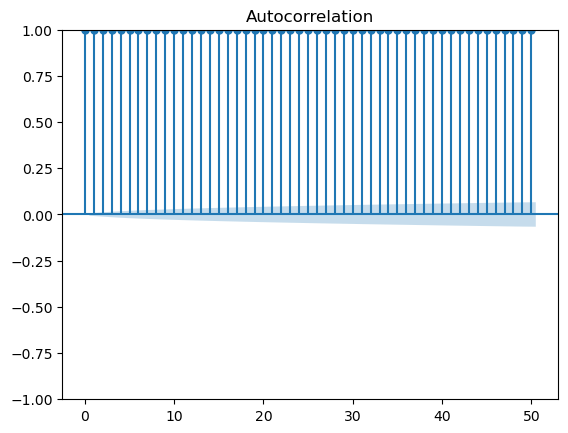

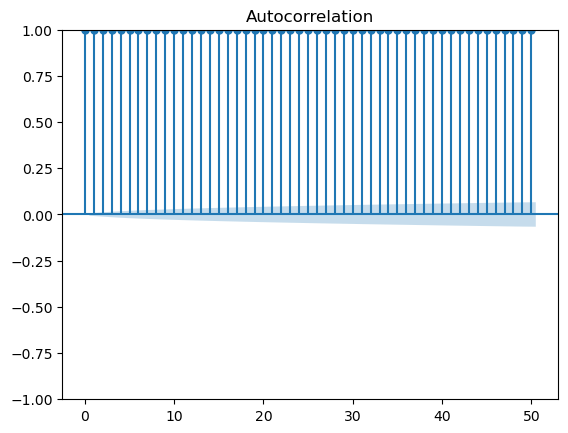

In [36]:
# log transformation - does nothing
log_pressure = np.log(df_1['pressure_1'])
plot_acf(log_pressure)

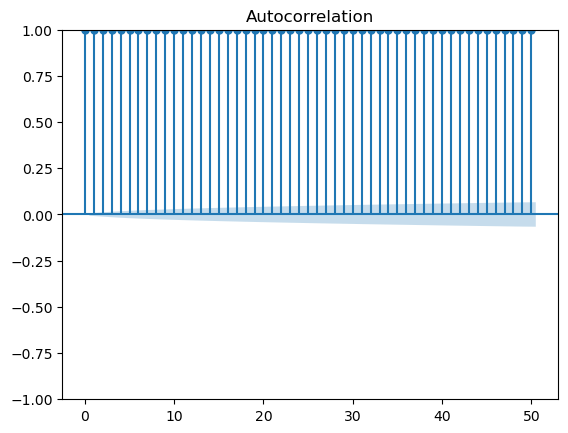

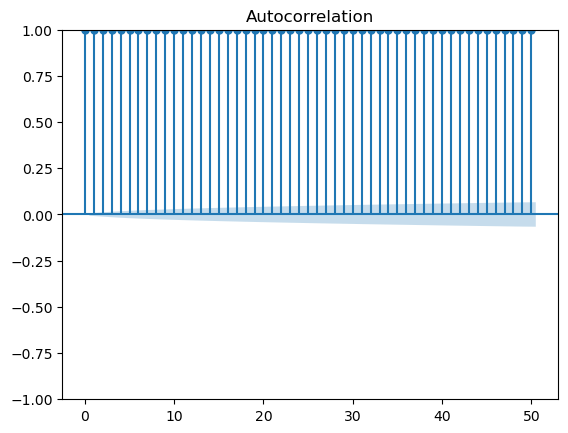

In [37]:
plot_acf(df_1['pressure_1'])

# Rolling Average Plots (archive)

In [39]:
rolling_average = df.electricity_1.rolling(1000).mean() # window = 1000

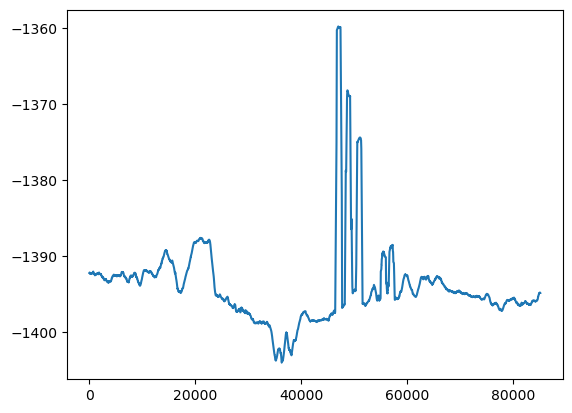

In [40]:
plt.plot(rolling_average)

In [173]:
rolling_average_2 = df_1.electricity_1.rolling(10000).mean() # window = 10000

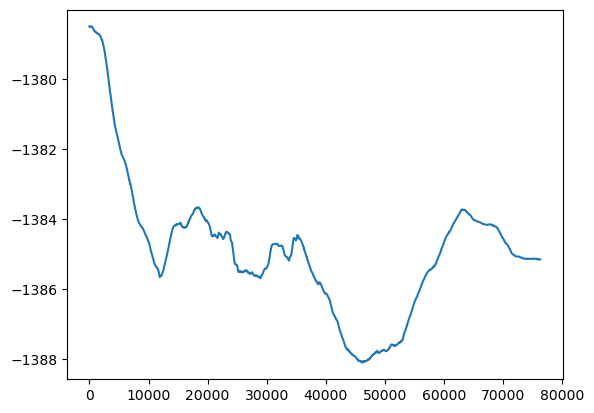

In [174]:
plt.plot(rolling_average_2)

<b> #2. pressure_1 </b>

In [175]:
rolling_average_pressure = df_1.pressure_1.rolling(1000).mean()

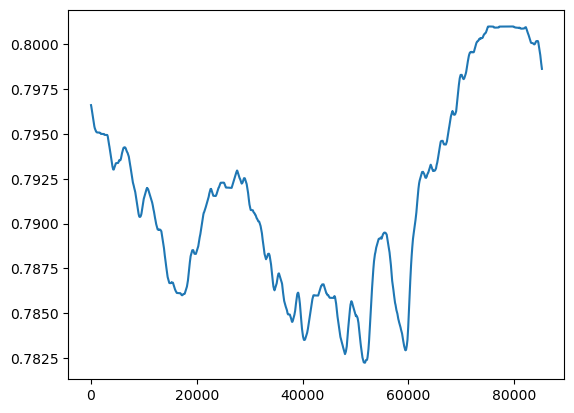

In [176]:
plt.plot(rolling_average_pressure)

In [177]:
rolling_average_pressure_1 = df_1.pressure_1.rolling(10000).mean()

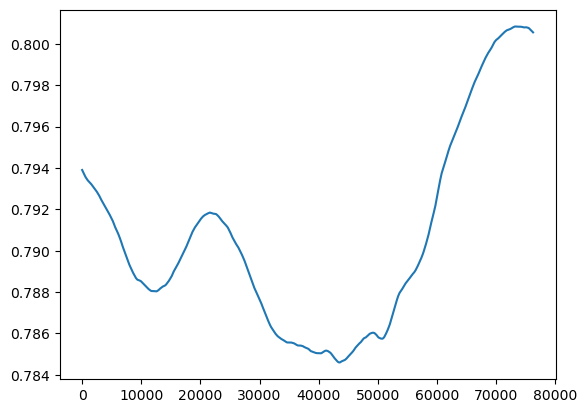

In [178]:
plt.plot(rolling_average_pressure_1)

In [179]:
rolling_average_electricity_2 = df_1.electricity_2.rolling(1000).mean()

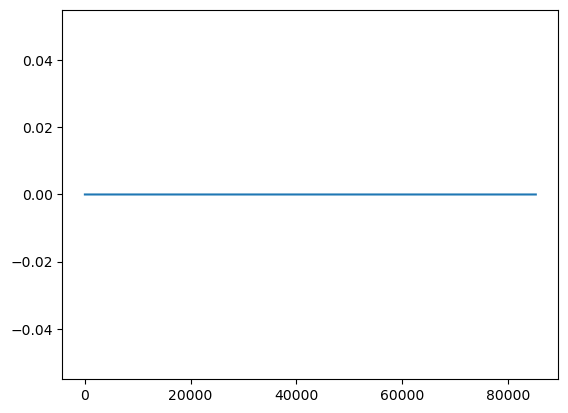

In [180]:
plt.plot(rolling_average_electricity_2)

# 대표값 찾기 

# consolidating the dataset (20240603)

In [18]:
df_1.groupby('time').head()

machine_code       day    time  door_open  electricity_1  \
86260             1  20240603       0          0        -1385.0   
86259             1  20240603       1          0        -1385.0   
86258             1  20240603       2          0        -1385.0   
86257             1  20240603       3          0        -1385.0   
86256             1  20240603       4          0        -1385.0   
...             ...       ...     ...        ...            ...   
4                 1  20240603  235955          0        -1379.0   
3                 1  20240603  235956          0        -1379.0   
2                 1  20240603  235957          0        -1379.0   
1                 1  20240603  235958          0        -1379.0   
0                 1  20240603  235959          0        -1379.0   

       electricity_2  gas_leak  is_maintenance  machine_type  network_status  \
86260            0.0         0               0             1               0   
86259            0.0         0               0             1               0   
86258            0.0         0               0             1               0   
86257            0.0         0               0             1               0   
86256            0.0         0               0             1               0   
...              ...       ...             ...           ...             ...   
4                0.0         0               0             1               0   
3                0.0         0               0             1               0   
2                0.0         0               0             1               0   
1                0.0         0               0             1               0   
0                0.0         0               0             1               0   

       ...  power_on  pressure_1  pressure_2  ssv1  ssv2  \
86260  ...         0       0.798       2.130     0     0   
86259  ...         0       0.798       2.130     0     0   
86258  ...         0       0.798       2.130     0     0   
86257  ...         0       0.798       2.144     0     0   
86256  ...         0       0.798       2.144     0     0   
...    ...       ...         ...         ...   ...   ...   
4      ...         0       0.797       2.137     0     0   
3      ...         0       0.797       2.137     0     0   
2      ...         0       0.797       2.137     0     0   
1      ...         0       0.797       2.137     0     0   
0      ...         0       0.797       2.137     0     0   

       status_electricity_1  status_electricity_2  status_pressure_1  \
86260                     0                     0                  0   
86259                     0                     0                  0   
86258                     0                     0                  0   
86257                     0                     0                  0   
86256                     0                     0                  0   
...                     ...                   ...                ...   
4                         0                     0                  0   
3                         0                     0                  0   
2                         0                     0                  0   
1                         0                     0                  0   
0                         0                     0                  0   

       status_pressure_2  weektime  
86260                  0         0  
86259                  0         0  
86258                  0         0  
86257                  0         0  
86256                  0         0  
...                  ...       ...  
4                      0         0  
3                      0         0  
2                      0         0  
1                      0         0  
0                      0         0  

[86261 rows x 22 columns]

In [187]:
consolidated_df = pd.DataFrame()
electricity_average = df_1['electricity_1'].dropna().rolling(59).mean()
consolidated_df['electricity_1'] = electricity_average

In [183]:
consolidated_df['electricity_1'].isnull().sum()

58

In [184]:
df_clean = df_1.copy()
df_clean.head()

machine_code       day  time  door_open  electricity_1  electricity_2  \
86260             1  20240603     0          0        -1385.0            0.0   
86259             1  20240603     1          0        -1385.0            0.0   
86258             1  20240603     2          0        -1385.0            0.0   
86257             1  20240603     3          0        -1385.0            0.0   
86256             1  20240603     4          0        -1385.0            0.0   

       gas_leak  is_maintenance  machine_type  network_status  ...  power_on  \
86260         0               0             1               0  ...         0   
86259         0               0             1               0  ...         0   
86258         0               0             1               0  ...         0   
86257         0               0             1               0  ...         0   
86256         0               0             1               0  ...         0   

       pressure_1  pressure_2  ssv1  ssv2  status_electricity_1  \
86260       0.798       2.130     0     0                     0   
86259       0.798       2.130     0     0                     0   
86258       0.798       2.130     0     0                     0   
86257       0.798       2.144     0     0                     0   
86256       0.798       2.144     0     0                     0   

       status_electricity_2  status_pressure_1  status_pressure_2  weektime  
86260                     0                  0                  0         0  
86259                     0                  0                  0         0  
86258                     0                  0                  0         0  
86257                     0                  0                  0         0  
86256                     0                  0                  0         0  

[5 rows x 22 columns]

# process_dataframe and query

In [30]:
def query(day, machine_code):
    use_machine_code = machine_code
    use_day = day
    # save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

    ###################################

    query = """
        SELECT *
        FROM {keyspace_name}.{table_name}
        WHERE machine_code = {query_machine_code}
        AND day = {query_day}
    """.format(
        keyspace_name = KEYSPACE,
        table_name = TABLE,
        query_machine_code = use_machine_code,
        query_day = use_day
    )

    query_result = cc.session.execute(query)
    ###################################

    # Pandas DataFrame으로 전환
    df_1 = pd.DataFrame(list(query_result)).sort_values(by = 'time')
    # df.to_csv(save_path, index=False)

    # print(df_1.shape)
    # print(df_1.head())
    return df_1



In [31]:
processed_dataframe_list = []
day_to_query = [20240603,20240604,20240605,20240606,20240607,20240608,20240609]
# df = query(20240603,1)
# df.columns
for day in day_to_query:
    df = query(day,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list.append(new_df)
del df
del new_df
final_df = pd.concat(processed_dataframe_list, axis = 1)

# final_df.head()

# final_df.T.shape

# final_df['Hour']

# April (20240401 ~ 20240430)

In [150]:
processed_dataframe_list_2 = []
start_date = 20240401

while start_date < 20240430:
    df = query(start_date,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list_2.append(new_df)
    start_date+=1
del df
del new_df
final_df_2 = pd.concat(processed_dataframe_list_2, axis = 0)

final_df_2.head()


Hour  machine_code       day  door_open  electricity_1  electricity_2  \
0     0             1  20240401          0        -1245.0            0.0   
1     1             1  20240401          0        -1245.0            0.0   
2     2             1  20240401          0        -1239.0            0.0   
3     3             1  20240401          0        -1236.0            0.0   
4     4             1  20240401          0        -1231.0            0.0   

   gas_leak  is_maintenance  machine_type  network_status  ...  power_on  \
0         0               0             1               0  ...         0   
1         0               0             1               0  ...         0   
2         0               0             1               0  ...         0   
3         0               0             1               0  ...         0   
4         0               0             1               0  ...         0   

   pressure_1  pressure_2  ssv1  ssv2  status_electricity_1  \
0       0.793       2.151     0     0                     0   
1       0.794       2.164     0     0                     0   
2       0.793       2.173     0     0                     0   
3       0.792       2.153     0     0                     0   
4       0.787       2.142     0     0                     0   

   status_electricity_2  status_pressure_1  status_pressure_2  weektime  
0                     0                  0                  0         0  
1                     0                  0                  0         0  
2                     0                  0                  0         0  
3                     0                  0                  0         0  
4                     0                  0                  0         0  

[5 rows x 22 columns]

In [151]:
final_df_22 = final_df_2.copy()
day_list = list(final_df_22['day'])
day = day_list[0]

In [152]:
# day_string = str(day_list[0])
# day_datetime = datetime.strptime(day_string, '%Y%m%d')
# day_datetime
new_date_list = []
for item in day_list:
    day_string = str(item)
    day_datetime = datetime.strptime(day_string, '%Y%m%d')
    new_date_list.append(day_datetime)

final_df_22['day'] = new_date_list

final_df_22['day']

0    2024-04-01
1    2024-04-01
2    2024-04-01
3    2024-04-01
4    2024-04-01
        ...    
19   2024-04-29
20   2024-04-29
21   2024-04-29
22   2024-04-29
23   2024-04-29
Name: day, Length: 696, dtype: datetime64[ns]

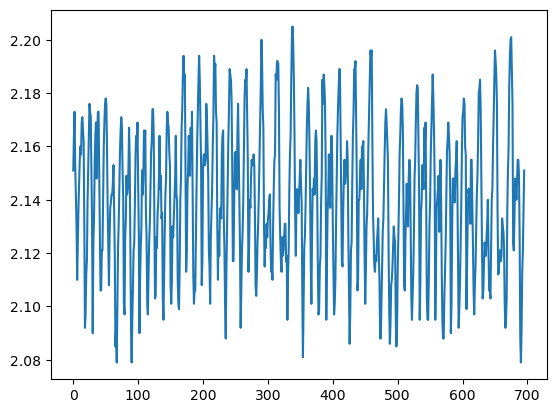

In [162]:
final_condensed_April = final_df_22[['day','Hour','pressure_2']]
final_condensed_April = final_condensed_April.reset_index()
del final_condensed_April['index']

final_condensed_April

plt.plot(final_condensed_April['pressure_2'])

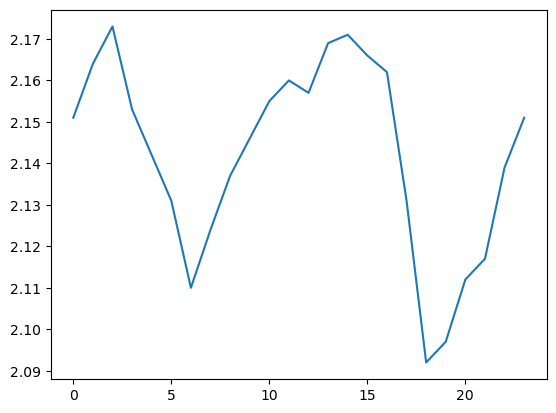

In [164]:
plt.plot(final_condensed_April['pressure_2'].head(24))

In [167]:
final_df_22['day']

0    2024-04-01
1    2024-04-01
2    2024-04-01
3    2024-04-01
4    2024-04-01
        ...    
19   2024-04-29
20   2024-04-29
21   2024-04-29
22   2024-04-29
23   2024-04-29
Name: day, Length: 696, dtype: datetime64[ns]

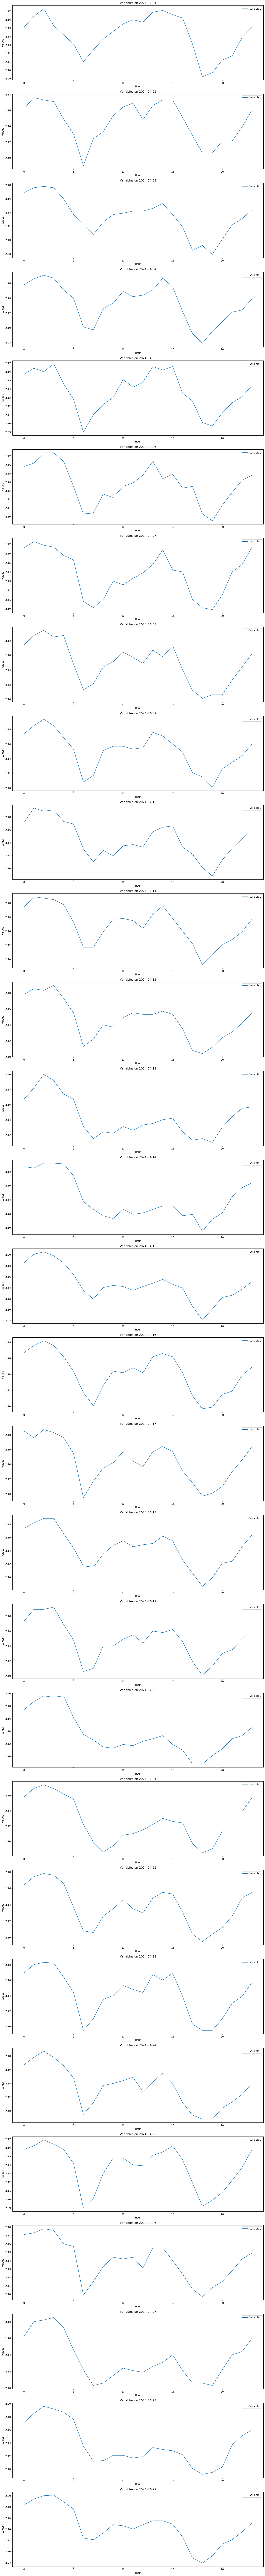

In [163]:
unique_dates = final_df_22['day'].unique()
fig, ax = plt.subplots(len(unique_dates), 1, figsize=(15, len(unique_dates) * 5))

for i, date in enumerate(unique_dates):
    daily_data = final_df_22[final_df_22['day'] == date]
    ax[i].plot(daily_data['Hour'], daily_data['pressure_2'], label='Variable1')
    # ax[i].plot(daily_data['Hour'], daily_data['Variable2'], label='Variable2')
    ax[i].set_title(f'Variables on {date.strftime("%Y-%m-%d")}')
    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Values')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [35]:
day_list = []
start_date = 20240401
while start_date < 20240430:
    day_list.append(start_date)
    start_date+=1


# Graphs and autocorrelation plots - plot_kmeans_results function

In [39]:
def plot_kmeans_results(variable_1,variable_2):
    rotation_angle = 60
    date_form = mdates.DateFormatter('%Y-%m-%d')
    # for key in keys:
    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_form)
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right")
    # RMS 시계열
    plt.plot(variable_1, variable_2, label='April')
    # 그래프 제목과 레이블 설정
    # plt.title(f'K-means Labels and RMS Values for key {key}, operating: {len(indices)},  non-operating: {len(labels_kmeans[start_index:end_index]) - len(indices)}', fontsize=16)
    # plt.xlabel('Day', fontsize=14)
    # plt.ylabel('Variable', fontsize=14)
    # 범례 추가
    plt.legend()
    # 그리드 추가
    plt.grid(True)
    # 그래프 표시
    plt.show()

In [130]:
final_22_condensed = final_df_22[['day','Hour','pressure_2']]
final_22_condensed = final_22_condensed.reset_index()
del final_22_condensed['index']


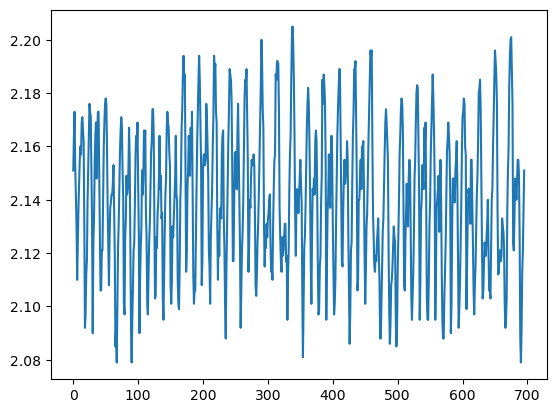

In [149]:
plt.plot(final_22_condensed['pressure_2'])

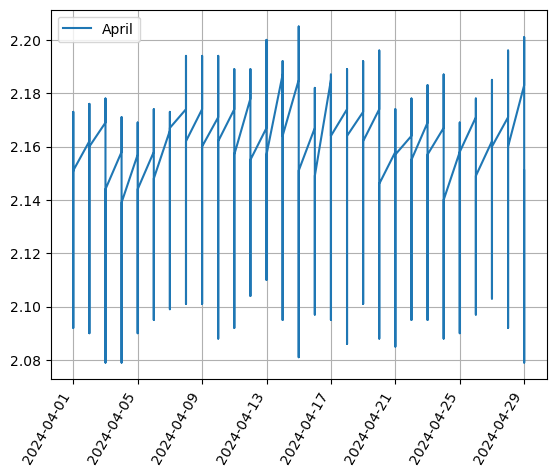

In [112]:
plot_kmeans_results(final_df_22['day'], final_df_22['pressure_2'])

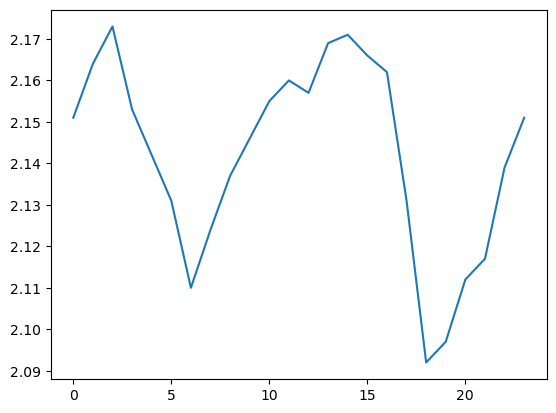

In [132]:
plt.plot(final_22_condensed['pressure_2'].head(24))

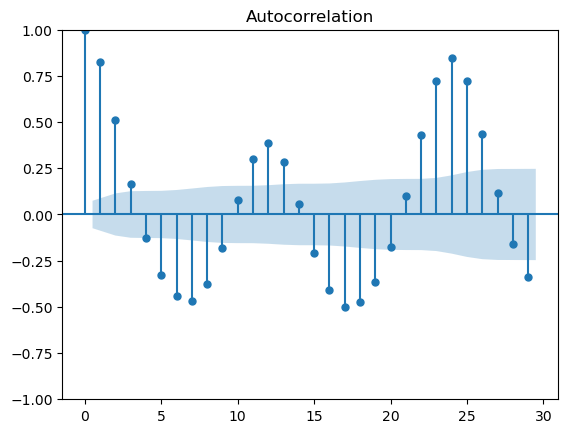

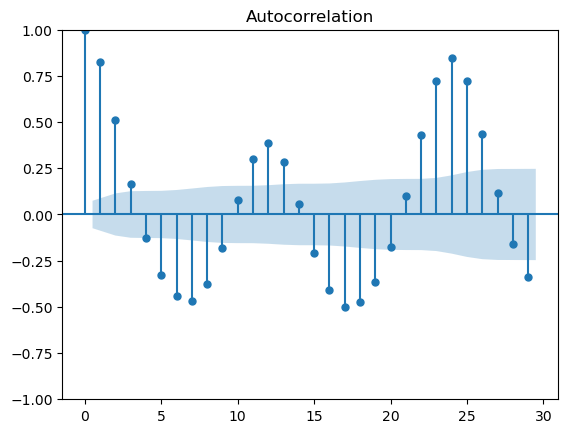

In [ ]:
plot_acf(final_df_22['pressure_2'])

# February (20240201 ~ 20240228)

In [25]:
processed_dataframe_list_3 = []
start_date = 20240201

while start_date < 20240228:
    df = query(start_date, 1)
    new_df = process_dataframe(df, 'max')
    processed_dataframe_list_3.append(new_df)
    start_date+=1

del df
del new_df

final_df_3 = pd.concat(processed_dataframe_list_3, axis =0)

final_df_3.head()

Hour  machine_code       day  door_open  electricity_1  electricity_2  \
0     0             1  20240201          0        -1408.0            0.0   
1     1             1  20240201          0        -1404.0            0.0   
2     2             1  20240201          0        -1408.0            0.0   
3     3             1  20240201          0        -1407.0            0.0   
4     4             1  20240201          0        -1401.0            0.0   

   gas_leak  is_maintenance  machine_type  network_status  ...  power_on  \
0         0               0             1               0  ...         0   
1         0               0             1               0  ...         0   
2         0               0             1               0  ...         0   
3         0               0             1               0  ...         0   
4         0               0             1               0  ...         0   

   pressure_1  pressure_2  ssv1  ssv2  status_electricity_1  \
0       0.781       2.167     0     0                     0   
1       0.784       2.173     0     0                     0   
2       0.784       2.174     0     0                     0   
3       0.781       2.169     0     0                     0   
4       0.773       2.155     0     0                     0   

   status_electricity_2  status_pressure_1  status_pressure_2  weektime  
0                     0                  0                  0         0  
1                     0                  0                  0         0  
2                     0                  0                  0         0  
3                     0                  0                  0         0  
4                     0                  0                  0         0  

[5 rows x 22 columns]

In [29]:
final_df_33 = final_df_3.copy()
day_list_2 = list(final_df_33['day'])

In [30]:
new_date_list_2 = []
for item in day_list_2:
    day_string = str(item)
    day_datetime = datetime.strptime(day_string, '%Y%m%d')
    new_date_list_2.append(day_datetime)

final_df_33['day'] = new_date_list_2

final_df_33['day']

0    2024-02-01
1    2024-02-01
2    2024-02-01
3    2024-02-01
4    2024-02-01
        ...    
19   2024-02-27
20   2024-02-27
21   2024-02-27
22   2024-02-27
23   2024-02-27
Name: day, Length: 644, dtype: datetime64[ns]

In [33]:
day_list_2 = []
start_date_2 =20240201
while start_date_2 < 20240228:
    day_list_2.append(start_date_2)
    start_date_2 +=1 


In [1]:
plot_kmeans_results(final_df_33['hour'],final_df_33['pressure_2'])

NameError: name 'plot_kmeans_results' is not defined

# Subplots (February and April)

In [ ]:
# subplots
fig = make_subplots(rows =2, cols =2)
fig.add_trace(
    go.Scatter(x=final_df_22['day'], y= final_df_22['pressure_1']),
    row=1, col=1
)
fig.add_trace(go.Scatter(x= final_df_22['day'], y= final_df_22['pressure_2']), row = 2, col =1)

fig.add_trace(
    go.Scatter(x= final_df_33['day'], y= final_df_33['pressure_1']),
    row=1, col=2
)

fig.add_trace(go.Scatter(x= final_df_33['day'], y= final_df_33['pressure_2']), row = 2, col =2)

In [ ]:
fig_2 = make_subplots(rows = 1, cols = 2)
fig_2.add_trace(go.Scatter(x= final_df_22['day'], y = final_df_22['electricity_1']), row = 1, col = 1)
fig_2.add_trace(go.Scatter(x = final_df_33['day'],y = final_df_33['electricity_1']), row = 1, col = 2)

In [ ]:
fig_3 = make_subplots(rows = 2, cols =1)
fig_3.add_trace(go.Scatter(x = final_df_33['day'], y = final_df_33['outside_temperature']), row = 1, col = 1)
fig_3.add_trace(go.Scatter(x = final_df_22['day'], y = final_df_22['outside_temperature']), row = 2, col = 1)


# pressure_1: visualization, analysis, etc - gibberish

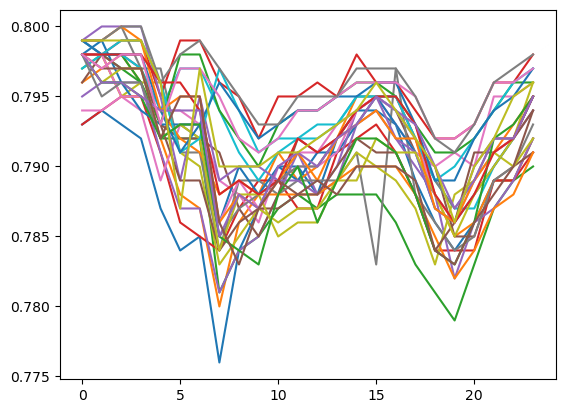

In [261]:
# visualization
plt.plot(final_df_2['pressure_1'])

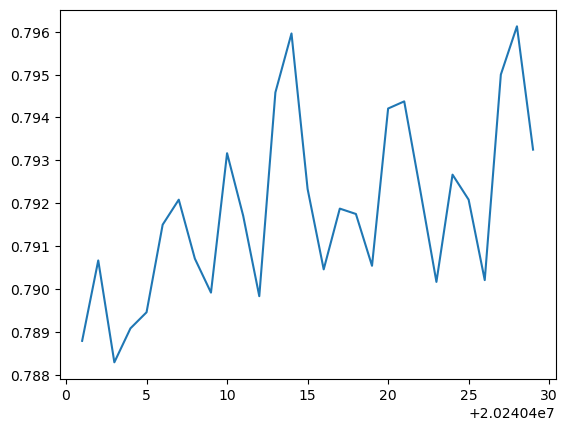

In [264]:
plt.plot(day_list, final_df_2['pressure_1'].mean())

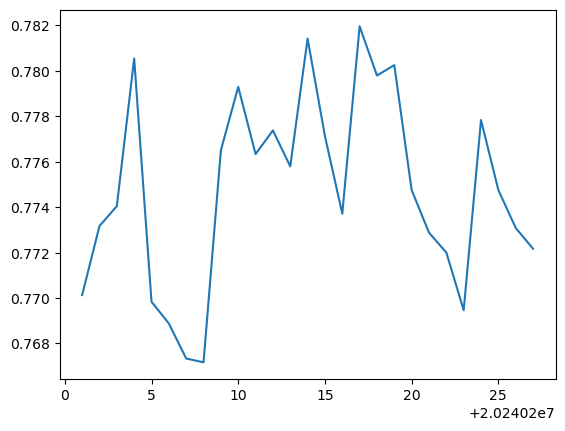

In [291]:
plt.plot(day_list_2, final_df_3['pressure_1'].mean())

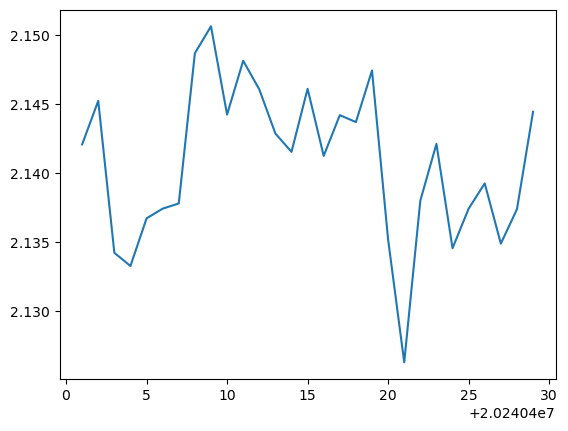

In [293]:
plt.plot(day_list, final_df_2['pressure_2'].mean())

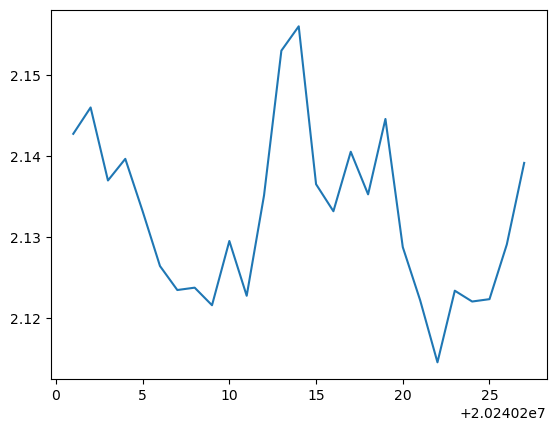

In [294]:
plt.plot(day_list_2, final_df_3['pressure_2'].mean())

# Linear Regression using our new dataframe

In [185]:
model_new = LinearRegression()

In [228]:
processed_dataframe_list = []
day_to_query = [20240603,20240604,20240605,20240606,20240607,20240608,20240609]
# df = query(20240603,1)
# df.columns
for day in day_to_query:
    df = query(day,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list.append(new_df)
del df
del new_df
final_df = pd.concat(processed_dataframe_list, axis = 1)

# final_df.T.shape

# final_df['Hour']

In [230]:
# takes the columns and turns them into numpy arrays
electricity_1_array = np.array(final_df_2['pressure_1']).reshape(-1,1)
maintenance_array_new = np.array(final_df_2['is_maintenance']).reshape(-1,1)

In [231]:
# splits the arrays into train and test sets
electricity_train, electricity_test, maintenance_train, maintenance_test = train_test_split(electricity_1_array, maintenance_array_new,random_state=104, test_size=0.25, shuffle=True)

In [232]:
# trains the model
model_electricity_pressure.fit(electricity_train, maintenance_train)

LinearRegression()

In [233]:
# uses the model to predict pressure_1
y_pred_maintenance = model_electricity_pressure.predict(electricity_test)

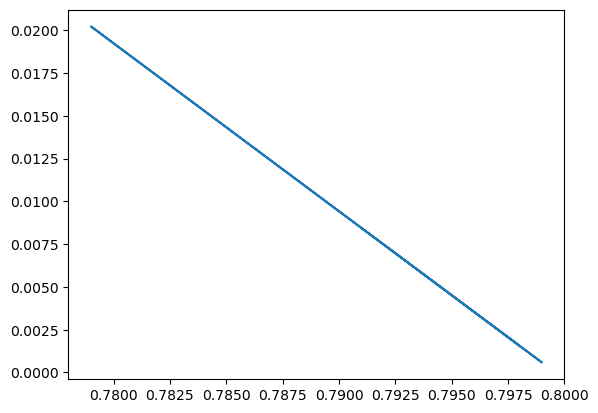

In [234]:
plt.plot(electricity_test, y_pred_maintenance)

# concatenated the dataframes - 20240603 ~ 20240609

In [ ]:
processed_dataframe_list = []
day_to_query = [20240603,20240604,20240605,20240606,20240607,20240608,20240609]
# df = query(20240603,1)
# df.columns
for day in day_to_query:
    df = query(day,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list.append(new_df)
del df
del new_df
final_df = pd.concat(processed_dataframe_list, axis = 1)

# final_df.T.shape

# final_df['Hour']

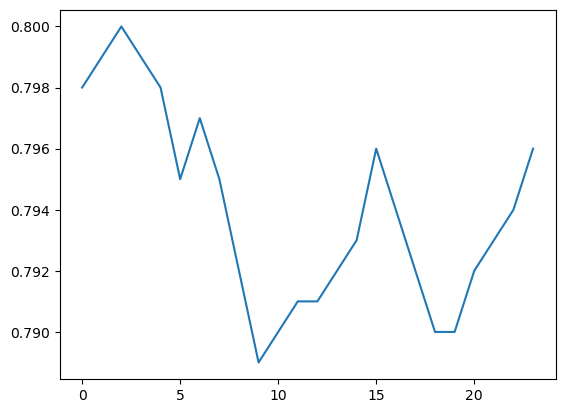

In [ ]:
df_1 = query(20240603,1)
df_2 = query(20240606,1)

df_1 = process_dataframe(df_1,'max')
df_2 = process_dataframe(df_2,'max')

# plt.plot(df_1['electricity_1'])
plt.plot(df_2['pressure_1'])

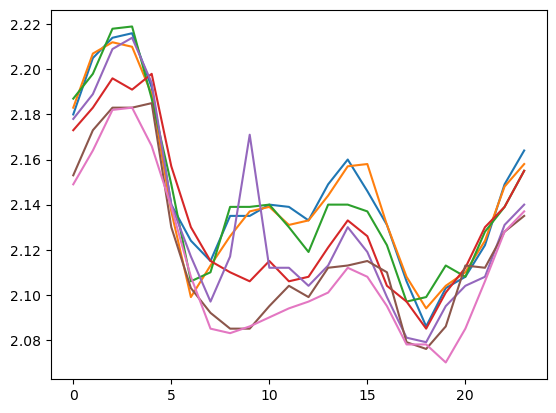

In [119]:
plt.plot(final_df['pressure_2'])

In [126]:
model_adjusted = LinearRegression()

In [128]:
electricity_new_array = np.array(final_df['electricity_1'])
outside_new_array = np.array(final_df['outside_temperature'])

In [129]:
electricity_new_train, electricity_new_test, outside_new_train, outside_new_test = train_test_split(electricity_new_array,outside_new_array,random_state = 42)

In [131]:
model_adjusted.fit(outside_new_train,electricity_new_train)

LinearRegression()

In [132]:
predicted_electricity = model_adjusted.predict(outside_new_test)

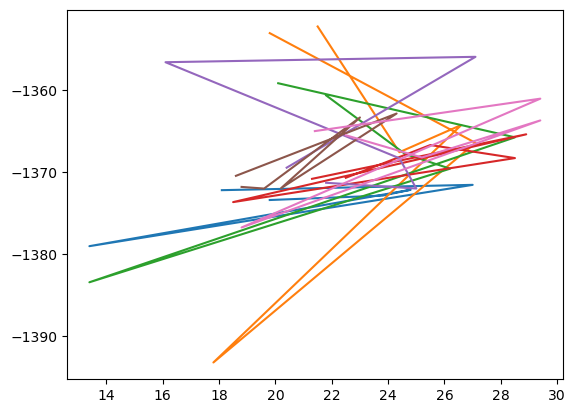

In [133]:
plt.plot(outside_new_test, predicted_electricity)

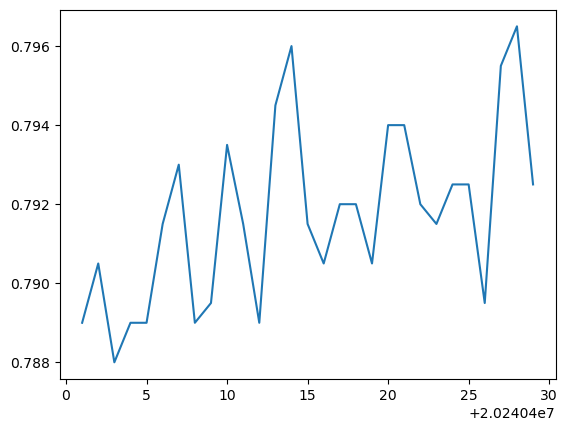

In [247]:
plt.plot(day_list,final_df_2['pressure_1'].median())

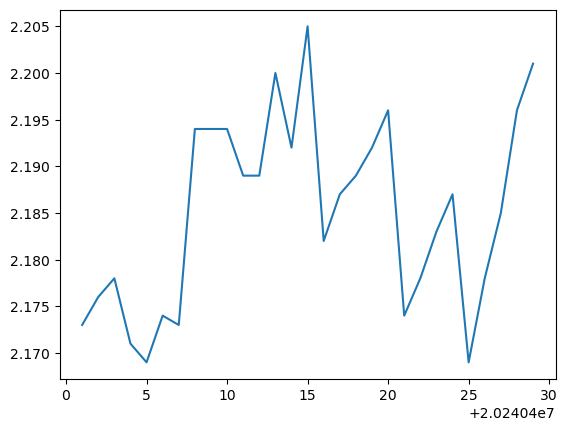

In [254]:
plt.plot(day_list, final_df_2['pressure_2'].max())

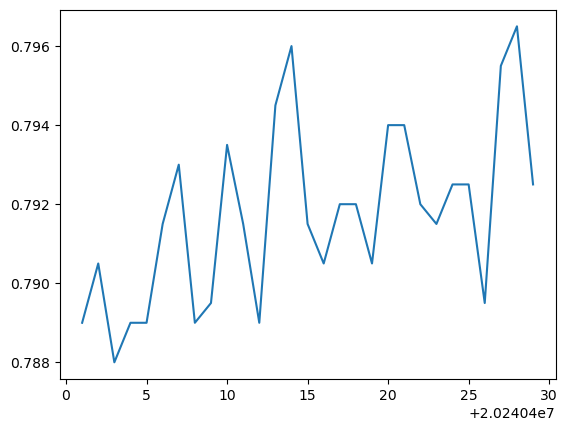

In [256]:
plt.plot(day_list, final_df_2['pressure_1'].median())

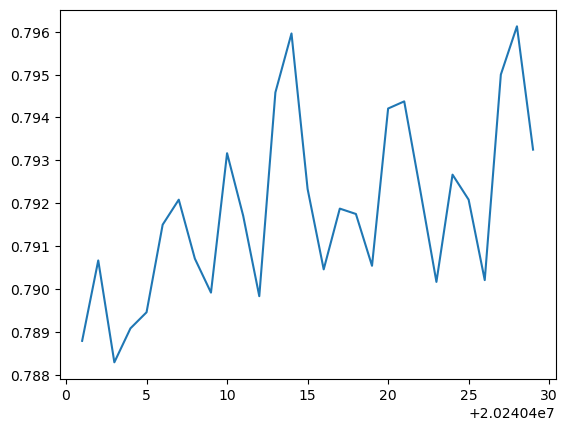

In [258]:
plt.plot(day_list, final_df_2['pressure_1'].mean())

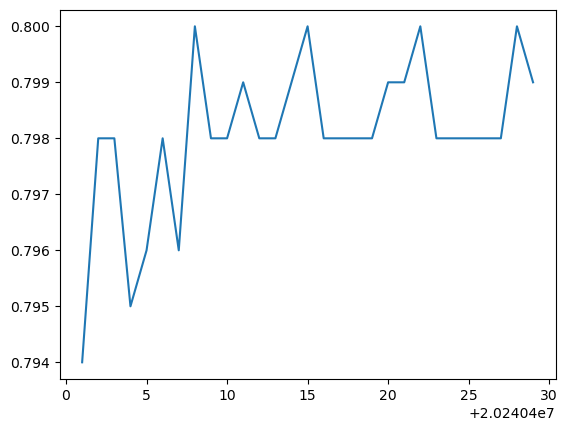

In [259]:
plt.plot(day_list, final_df_2['pressure_1'].max())

# final_df_22 (April) final_df_33 (February)

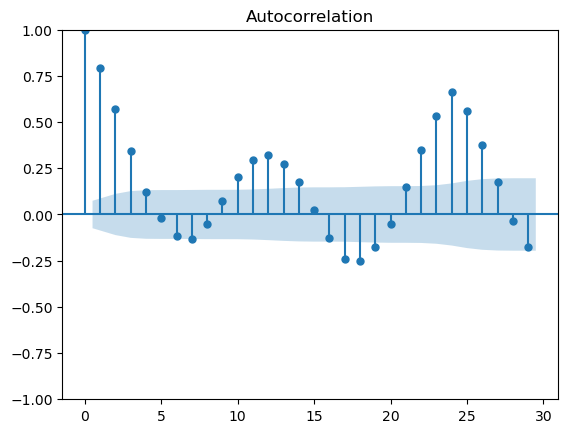

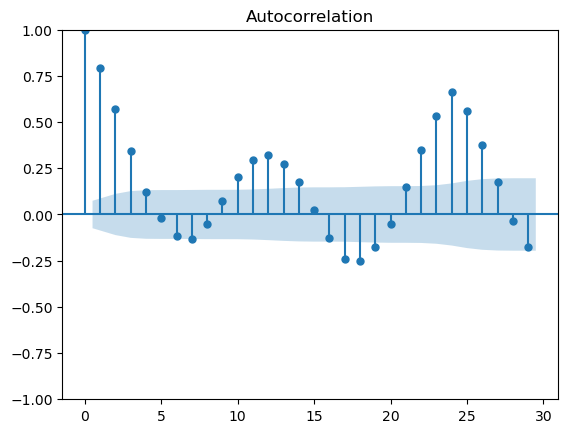

In [89]:
fig_new = make_subplots(rows = 1, cols = 2)
plot_acf(final_df_22['pressure_1'])

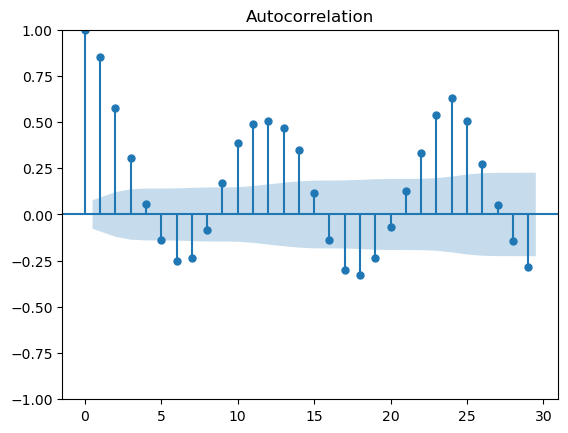

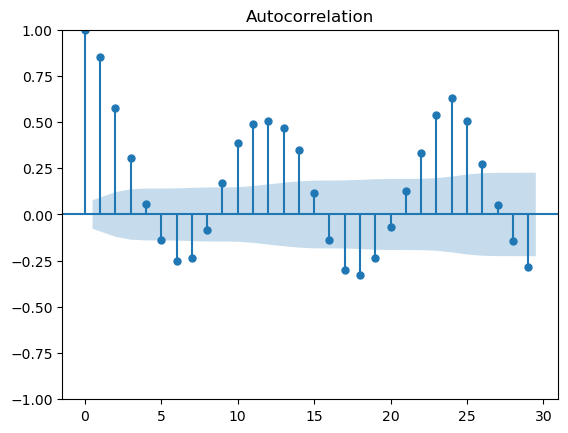

In [90]:
plot_acf(final_df_33['pressure_1'])

In [113]:
# processed_dataframe_list_4 = []
# start_date = 20240301

# while start_date < 20240331:
#     df_2 = query(start_date, 1)
#     new_df_2 = process_dataframe(df_2, 'max')
#     processed_dataframe_list_4.append(new_df_2)
#     start_date+=1

# del df_2
# del new_df_2

# final_df_mar = pd.concat(processed_dataframe_list_4, axis =0)

# final_df_mar.head()

In [102]:
master_list_2 = []
master_list_2.append(final_df_33.copy())
master_list_2.append(final_df_22.copy())

In [103]:
big_df = pd.concat(master_list_2, axis = 0)

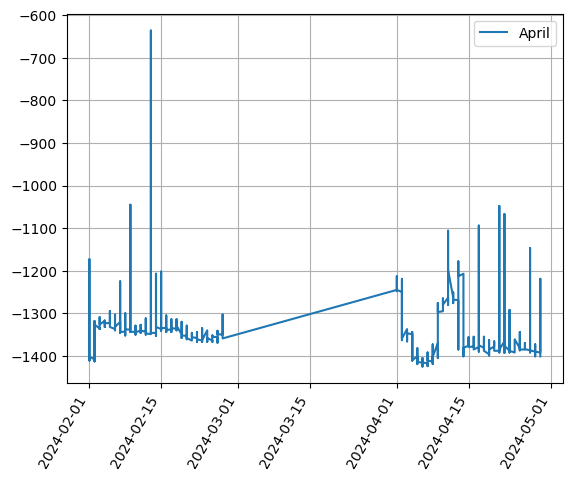

In [107]:
plot_kmeans_results(big_df['day'],big_df['electricity_1'])

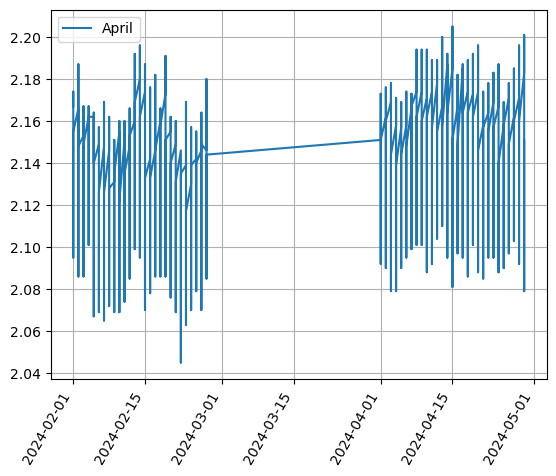

In [108]:
plot_kmeans_results(big_df['day'],big_df['pressure_2'])

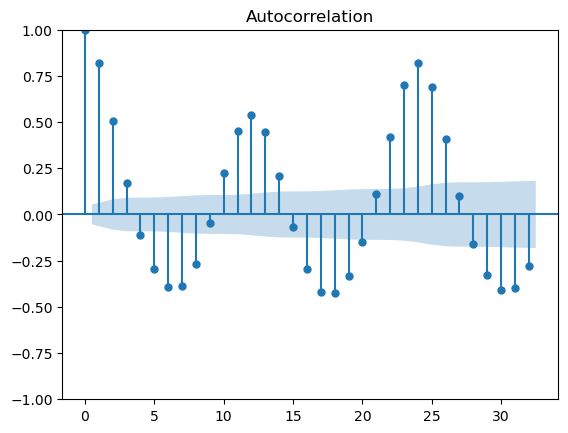

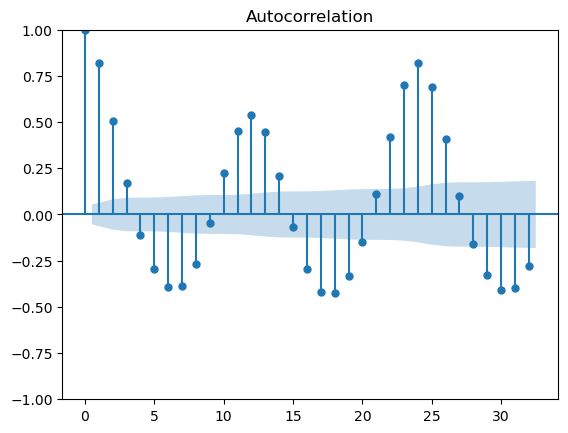

In [116]:
plot_acf(big_df['pressure_2'])

In [125]:
df_2 = query(20240301, 1)
new_df_2 = process_dataframe(df_2, 'max')
day_list_3 = list(new_df_2['day'])
new_date_list_3 = []
for item in day_list_3:
    day_string = str(item)
    day_datetime = datetime.strptime(day_string, '%Y%m%d')
    new_date_list_3.append(day_datetime)

new_df_2['day'] = new_date_list_3

new_df_2


Hour  machine_code        day  door_open  electricity_1  electricity_2  \
0      0             1 2024-03-01          0        -1329.0            0.0   
1      1             1 2024-03-01          0        -1344.0            0.0   
2      2             1 2024-03-01          0        -1341.0            0.0   
3      3             1 2024-03-01          0        -1347.0            0.0   
4      4             1 2024-03-01          0        -1361.0            0.0   
5      5             1 2024-03-01          0        -1361.0            0.0   
6      6             1 2024-03-01          0        -1367.0            0.0   
7      7             1 2024-03-01          0        -1369.0            0.0   
8      8             1 2024-03-01          0        -1364.0            0.0   
9      9             1 2024-03-01          0        -1359.0            0.0   
10    10             1 2024-03-01          0        -1349.0            0.0   
11    11             1 2024-03-01          0        -1347.0            0.0   
12    12             1 2024-03-01          0        -1358.0            0.0   
13    13             1 2024-03-01          0        -1359.0            0.0   
14    14             1 2024-03-01          0        -1361.0            0.0   
15    15             1 2024-03-01          0        -1356.0            0.0   
16    16             1 2024-03-01          0        -1356.0            0.0   
17    17             1 2024-03-01          0        -1359.0            0.0   
18    18             1 2024-03-01          0        -1355.0            0.0   
19    19             1 2024-03-01          0        -1358.0            0.0   
20    20             1 2024-03-01          0        -1353.0            0.0   
21    21             1 2024-03-01          0        -1353.0            0.0   
22    22             1 2024-03-01          0        -1352.0            0.0   
23    23             1 2024-03-01          0        -1346.0            0.0   

    gas_leak  is_maintenance  machine_type  network_status  ...  power_on  \
0          0               0             1               0  ...         0   
1          0               0             1               0  ...         0   
2          0               0             1               0  ...         0   
3          0               0             1               0  ...         0   
4          0               0             1               0  ...         0   
5          0               0             1               0  ...         0   
6          0               0             1               0  ...         0   
7          0               0             1               0  ...         0   
8          0               0             1               0  ...         0   
9          0               0             1               0  ...         0   
10         0               0             1               0  ...         0   
11         0               0             1               0  ...         0   
12         0               0             1               0  ...         0   
13         0               0             1               0  ...         0   
14         0               0             1               0  ...         0   
15         0               0             1               0  ...         0   
16         0               0             1               0  ...         0   
17         0               0             1               0  ...         0   
18         0               0             1               0  ...         0   
19         0               0             1               0  ...         0   
20         0               0             1               0  ...         0   
21         0               0             1               0  ...         0   
22         0               0             1               0  ...         0   
23         0               0             1               0  ...         0   

    pressure_1  pressure_2  ssv1  ssv2  status_electricity_1  \
0        0.780       2.133     0     0                     0   

In [126]:
processed_dataframe_list_4 = []
start_date = 20240301

while start_date < 20240330:
    df_2 = query(start_date, 1)
    new_df_2 = process_dataframe(df_2, 'max')
    processed_dataframe_list_4.append(new_df_2)
    start_date+=1

del df_2
del new_df_2

final_df_mar = pd.concat(processed_dataframe_list_4, axis =0)

final_df_mar.head()

KeyError: 'time'